In [15]:
# Bibliotecas para análise de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Processamento de dados
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set(font_scale=1.2)

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Conexão com o banco de dados
import os
import sys
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# Carregar variáveis de ambiente do arquivo .env
load_dotenv()

# Configuração da conexão
DB_USER = os.getenv("DB_USER", "postgres")
DB_PASSWORD = os.getenv("DB_PASSWORD", "postgres")
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("DB_NAME", "academia")

# String de conexão
conn_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Criar engine de conexão
try:
    engine = create_engine(conn_string)
    # Testar a conexão
    with engine.connect() as conn:
        result = conn.execute(text("SELECT 1")).fetchone()
    print("Conexão com o banco de dados estabelecida com sucesso!")
except Exception as e:
    print(f"Erro ao conectar ao banco de dados: {e}")

Conexão com o banco de dados estabelecida com sucesso!


In [3]:
# Consulta para obter dados dos alunos
query_alunos = """
SELECT 
    a.id as aluno_id, 
    a.nome, 
    a.data_inscricao, 
    a.ativo,
    p.id as plano_id, 
    p.nome as plano_nome,
    p.valor_mensal
FROM 
    alunos a
JOIN 
    planos p ON a.plano_id = p.id
"""

# Consulta para obter check-ins dos alunos
query_checkins = """
SELECT 
    c.aluno_id, 
    c.data_entrada, 
    c.data_saida, 
    c.duracao_minutos
FROM 
    checkins c
ORDER BY 
    c.aluno_id, c.data_entrada
"""

# Executar as consultas
try:
    # Carregar dados em DataFrames
    df_alunos = pd.read_sql(query_alunos, engine)
    df_checkins = pd.read_sql(query_checkins, engine)
    
    # Converter colunas de data para datetime
    df_alunos['data_inscricao'] = pd.to_datetime(df_alunos['data_inscricao'])
    df_checkins['data_entrada'] = pd.to_datetime(df_checkins['data_entrada'])
    df_checkins['data_saida'] = pd.to_datetime(df_checkins['data_saida'])
    
    print(f"Dados carregados:\n- {len(df_alunos)} alunos\n- {len(df_checkins)} check-ins")
except Exception as e:
    print(f"Erro ao carregar dados: {e}")

# Verificar os dados carregados
print("\nDados dos alunos:")
print(df_alunos.head())

print("\nDados dos check-ins:")
print(df_checkins.head())

Dados carregados:
- 108 alunos
- 6914 check-ins

Dados dos alunos:
   aluno_id             nome data_inscricao  ativo  plano_id plano_nome  \
0       553  Marcelo Pereira     2024-06-01      1         2    Premium   
1       554   Larissa Araújo     2024-02-24      0         3        VIP   
2       555   Yasmin Almeida     2024-08-17      1         1     Básico   
3       556    Carlos Santos     2024-08-28      1         1     Básico   
4       557    Manuela Nunes     2024-06-25      1         2    Premium   

   valor_mensal  
0         149.9  
1         299.9  
2          99.9  
3          99.9  
4         149.9  

Dados dos check-ins:
   aluno_id        data_entrada          data_saida  duracao_minutos
0       553 2024-06-04 08:17:00 2024-06-04 08:58:00               41
1       553 2024-06-05 22:32:00 2024-06-05 23:40:00               68
2       553 2024-06-08 10:34:00 2024-06-08 12:32:00              118
3       553 2024-06-09 08:46:00 2024-06-09 10:16:00               90
4      


Estatísticas dos alunos:
         aluno_id               nome                 data_inscricao  \
count   108.00000                108                            108   
unique        NaN                107                            NaN   
top           NaN  Henrique Oliveira                            NaN   
freq          NaN                  2                            NaN   
mean    606.50000                NaN  2024-08-21 13:29:39.303330304   
min     553.00000                NaN            2024-02-24 00:00:00   
25%     579.75000                NaN            2024-06-24 12:00:00   
50%     606.50000                NaN            2024-08-12 12:00:00   
75%     633.25000                NaN            2024-09-29 18:00:00   
max     660.00000                NaN     2025-04-04 19:45:02.075041   
std      31.32092                NaN                            NaN   

             ativo    plano_id plano_nome  valor_mensal  
count   108.000000  108.000000        108    108.000000  
uniqu

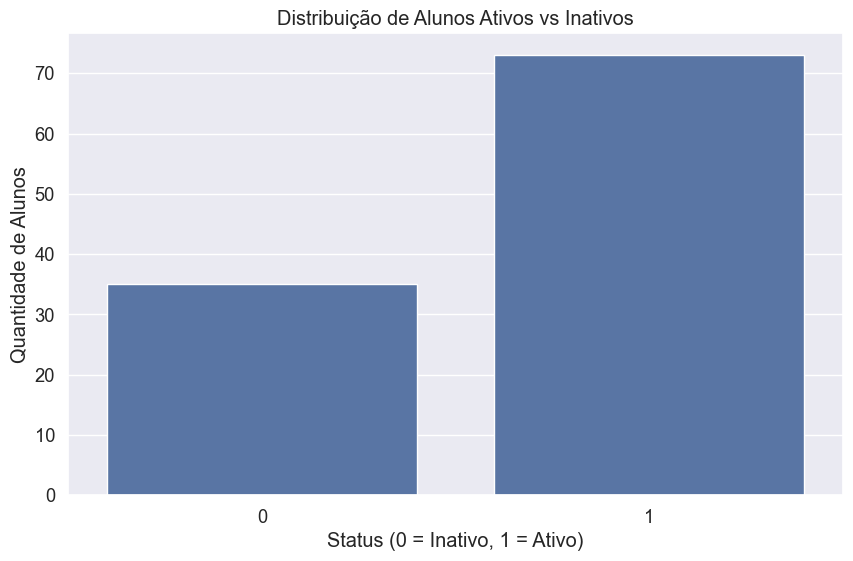

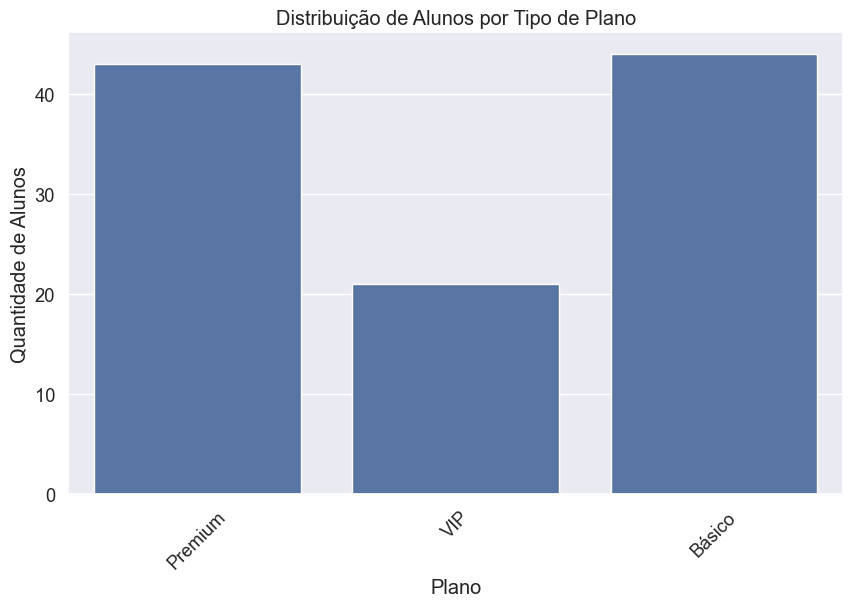

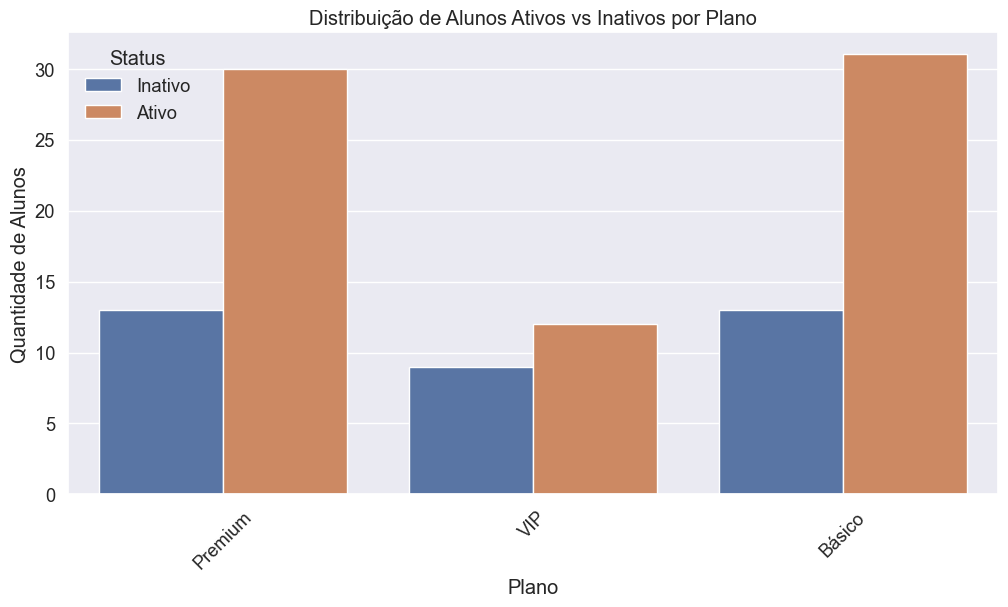


Média de check-ins por semana por status:
status
Ativo      7.448842
Inativo    0.957435
Name: checkins_por_semana, dtype: float64


In [14]:
# Estatísticas básicas dos alunos
print("\nEstatísticas dos alunos:")
print(df_alunos.describe(include='all'))

# Verificar distribuição de alunos ativos vs inativos
plt.figure(figsize=(10, 6))
sns.countplot(x='ativo', data=df_alunos)
plt.title('Distribuição de Alunos Ativos vs Inativos')
plt.xlabel('Status (0 = Inativo, 1 = Ativo)')
plt.ylabel('Quantidade de Alunos')
plt.show()

# Verificar distribuição por tipo de plano
plt.figure(figsize=(10, 6))
sns.countplot(x='plano_nome', data=df_alunos)
plt.title('Distribuição de Alunos por Tipo de Plano')
plt.xlabel('Plano')
plt.ylabel('Quantidade de Alunos')
plt.xticks(rotation=45)
plt.show()

# Distribuição de alunos ativos vs inativos por plano
plt.figure(figsize=(12, 6))
sns.countplot(x='plano_nome', hue='ativo', data=df_alunos)
plt.title('Distribuição de Alunos Ativos vs Inativos por Plano')
plt.xlabel('Plano')
plt.ylabel('Quantidade de Alunos')
plt.xticks(rotation=45)
plt.legend(title='Status', labels=['Inativo', 'Ativo'])
plt.show()

# Análise de check-ins
# Calcular quantidade de check-ins por aluno
checkins_por_aluno = df_checkins.groupby('aluno_id').size().reset_index(name='total_checkins')

# Juntar com dados de alunos
df_analise = pd.merge(df_alunos, checkins_por_aluno, on='aluno_id', how='left')
df_analise['total_checkins'] = df_analise['total_checkins'].fillna(0)

# Calcular dias entre a data atual e a inscrição (usando valor absoluto para funcionar com datas futuras)
data_atual = datetime.now()
df_analise['dias_entre_inscricao'] = abs((data_atual - df_analise['data_inscricao']).dt.days)

# Para evitar divisão por zero
df_analise['dias_entre_inscricao'] = df_analise['dias_entre_inscricao'].replace(0, 1)

# Calcular média de check-ins por semana
df_analise['checkins_por_semana'] = (df_analise['total_checkins'] / (df_analise['dias_entre_inscricao'] / 7)).fillna(0)

# Criar uma coluna de status textual para melhor visualização
df_analise['status'] = df_analise['ativo'].map({1: 'Ativo', 0: 'Inativo'})

# Imprimir a média de check-ins por semana para cada grupo
print("\nMédia de check-ins por semana por status:")
print(df_analise.groupby('status')['checkins_por_semana'].mean())



Calculando features para todos os alunos...
Features calculadas para 108 alunos.
   total_checkins  media_checkins_semana  dias_desde_ultimo_checkin  \
0             119               2.704545                          0   
1              30               0.517241                          0   
2              83               2.515152                          0   
3              99               3.150000                          0   
4             106               2.612676                          0   

   duracao_media_minutos  variacao_duracao  dias_consecutivos_max  \
0              82.613445         29.289065                      7   
1              64.766667         37.190732                      2   
2              79.313253         30.818085                      4   
3              77.464646         28.102695                      5   
4              82.613208         29.464287                      5   

   percentual_manha  percentual_tarde  percentual_noite  aluno_id  \
0       

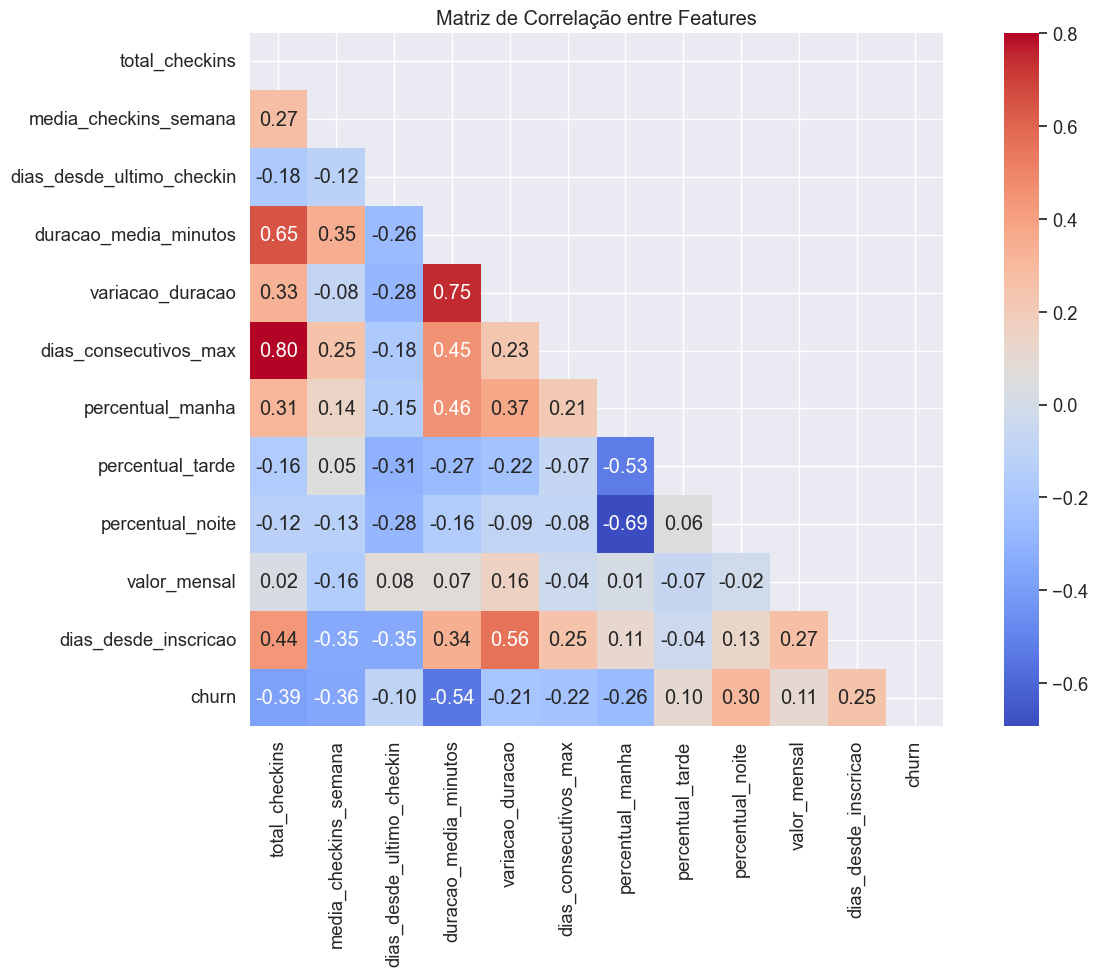


Correlações com o churn:
churn                        1.000000
percentual_noite             0.302407
dias_desde_inscricao         0.252532
valor_mensal                 0.106399
percentual_tarde             0.104438
dias_desde_ultimo_checkin   -0.099103
variacao_duracao            -0.208132
dias_consecutivos_max       -0.217735
percentual_manha            -0.259500
media_checkins_semana       -0.358679
total_checkins              -0.386441
duracao_media_minutos       -0.544161
Name: churn, dtype: float64


In [5]:
# Função para calcular features por aluno
def calcular_features_aluno(aluno_id):
    # Filtrar check-ins do aluno
    checkins_aluno = df_checkins[df_checkins['aluno_id'] == aluno_id]
    
    # Se não houver check-ins, retornar valores padrão
    if len(checkins_aluno) == 0:
        return {
            'total_checkins': 0,
            'media_checkins_semana': 0,
            'dias_desde_ultimo_checkin': 999,  # Valor alto para indicar inatividade
            'duracao_media_minutos': 0,
            'variacao_duracao': 0,
            'dias_consecutivos_max': 0,
            'percentual_manha': 0,
            'percentual_tarde': 0,
            'percentual_noite': 0
        }
    
    # Obter informações do aluno
    aluno_info = df_alunos[df_alunos['aluno_id'] == aluno_id].iloc[0]
    data_inscricao = aluno_info['data_inscricao']
    
    # Calcular total de check-ins
    total_checkins = len(checkins_aluno)
    
    # Calcular dias desde a inscrição
    dias_desde_inscricao = (datetime.now() - data_inscricao).days
    
    # Calcular média de check-ins por semana
    semanas_desde_inscricao = max(1, dias_desde_inscricao / 7)
    media_checkins_semana = total_checkins / semanas_desde_inscricao
    
    # Calcular dias desde o último check-in
    ultimo_checkin = checkins_aluno['data_entrada'].max()
    dias_desde_ultimo_checkin = (datetime.now() - ultimo_checkin).days
    
    # Calcular duração média das visitas
    checkins_com_duracao = checkins_aluno[checkins_aluno['duracao_minutos'].notnull()]
    duracao_media_minutos = checkins_com_duracao['duracao_minutos'].mean() if len(checkins_com_duracao) > 0 else 0
    
    # Calcular variação de duração (desvio padrão)
    variacao_duracao = checkins_com_duracao['duracao_minutos'].std() if len(checkins_com_duracao) > 0 else 0
    
    # Calcular padrões de horário (manhã: 6-12h, tarde: 12-18h, noite: 18-23h)
    checkins_aluno['hora'] = checkins_aluno['data_entrada'].dt.hour
    total_validos = len(checkins_aluno)
    
    manha = ((checkins_aluno['hora'] >= 6) & (checkins_aluno['hora'] < 12)).sum()
    tarde = ((checkins_aluno['hora'] >= 12) & (checkins_aluno['hora'] < 18)).sum()
    noite = ((checkins_aluno['hora'] >= 18) & (checkins_aluno['hora'] <= 23)).sum()
    
    percentual_manha = manha / total_validos if total_validos > 0 else 0
    percentual_tarde = tarde / total_validos if total_validos > 0 else 0
    percentual_noite = noite / total_validos if total_validos > 0 else 0
    
    # Calcular sequências de dias consecutivos (máximo)
    if total_checkins > 1:
        # Ordenar check-ins por data
        checkins_ordenados = checkins_aluno.sort_values('data_entrada')
        # Converter para data (sem hora)
        checkins_ordenados['data'] = checkins_ordenados['data_entrada'].dt.date
        # Remover duplicatas (considerar apenas uma visita por dia)
        datas_unicas = checkins_ordenados['data'].drop_duplicates().reset_index(drop=True)
        
        # Calcular diferenças entre datas consecutivas
        datas_unicas = pd.Series(datas_unicas)
        diferencas = [(datas_unicas.iloc[i+1] - datas_unicas.iloc[i]).days for i in range(len(datas_unicas)-1)]
        
        # Identificar sequências consecutivas (diferença = 1 dia)
        sequencias = []
        seq_atual = 1
        
        for diff in diferencas:
            if diff == 1:
                seq_atual += 1
            else:
                sequencias.append(seq_atual)
                seq_atual = 1
        
        sequencias.append(seq_atual)
        dias_consecutivos_max = max(sequencias)
    else:
        dias_consecutivos_max = 1 if total_checkins == 1 else 0
    
    return {
        'total_checkins': total_checkins,
        'media_checkins_semana': media_checkins_semana,
        'dias_desde_ultimo_checkin': dias_desde_ultimo_checkin,
        'duracao_media_minutos': duracao_media_minutos,
        'variacao_duracao': variacao_duracao,
        'dias_consecutivos_max': dias_consecutivos_max,
        'percentual_manha': percentual_manha,
        'percentual_tarde': percentual_tarde,
        'percentual_noite': percentual_noite
    }

# Calcular features para todos os alunos
print("Calculando features para todos os alunos...")
features_lista = []

for aluno_id in df_alunos['aluno_id']:
    # Obter dados básicos do aluno
    aluno_info = df_alunos[df_alunos['aluno_id'] == aluno_id].iloc[0]
    
    # Calcular features do aluno
    features = calcular_features_aluno(aluno_id)
    
    # Adicionar informações do aluno e features calculadas
    features.update({
        'aluno_id': aluno_id,
        'nome': aluno_info['nome'],
        'plano_id': aluno_info['plano_id'],
        'plano_nome': aluno_info['plano_nome'],
        'valor_mensal': aluno_info['valor_mensal'],
        'dias_desde_inscricao': abs((datetime.now() - aluno_info['data_inscricao']).days),
        'churn': 1 - aluno_info['ativo']  # Converter 'ativo' para 'churn' (nossa variável alvo)
    })
    
    features_lista.append(features)

# Criar DataFrame com todas as features
df_features = pd.DataFrame(features_lista)
print(f"Features calculadas para {len(df_features)} alunos.")

# Visualizar o DataFrame de features
print(df_features.head())

# Explorar a correlação entre as features e o churn
plt.figure(figsize=(14, 10))
features_numericas = df_features.select_dtypes(include=[np.number]).drop(['aluno_id', 'plano_id'], axis=1)
corr = features_numericas.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matriz de Correlação entre Features')
plt.tight_layout()
plt.show()

# Analisar correlações com o churn
correlacoes_churn = corr['churn'].sort_values(ascending=False)
print("\nCorrelações com o churn:")
print(correlacoes_churn)

In [6]:
# Verificar se há valores ausentes
print("Verificando valores ausentes:")
print(df_features.isnull().sum())

# Preencher valores ausentes, se houver
df_features = df_features.fillna(0)

# Separar features e target
# Remover colunas que não devem ser usadas como features
features_para_remover = ['aluno_id', 'nome', 'churn']
X = df_features.drop(features_para_remover, axis=1)
y = df_features['churn']

# Separar features categóricas e numéricas
features_categoricas = ['plano_nome']
features_numericas = X.select_dtypes(include=[np.number]).columns.tolist()

# Verificar as features selecionadas
print(f"\nFeatures categóricas: {features_categoricas}")
print(f"Features numéricas: {features_numericas}")

# Criar pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_categoricas)
    ]
)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} exemplos")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} exemplos")
print(f"Distribuição de classes (treino): {y_train.value_counts()}")
print(f"Distribuição de classes (teste): {y_test.value_counts()}")


Verificando valores ausentes:
total_checkins               0
media_checkins_semana        0
dias_desde_ultimo_checkin    0
duracao_media_minutos        0
variacao_duracao             0
dias_consecutivos_max        0
percentual_manha             0
percentual_tarde             0
percentual_noite             0
aluno_id                     0
nome                         0
plano_id                     0
plano_nome                   0
valor_mensal                 0
dias_desde_inscricao         0
churn                        0
dtype: int64

Features categóricas: ['plano_nome']
Features numéricas: ['total_checkins', 'media_checkins_semana', 'dias_desde_ultimo_checkin', 'duracao_media_minutos', 'variacao_duracao', 'dias_consecutivos_max', 'percentual_manha', 'percentual_tarde', 'percentual_noite', 'plano_id', 'valor_mensal', 'dias_desde_inscricao']
Tamanho do conjunto de treino: 86 exemplos
Tamanho do conjunto de teste: 22 exemplos
Distribuição de classes (treino): churn
0    58
1    28
Name: c

In [7]:
################################################################################
# 7. Treinamento do Modelo
################################################################################

# Criar pipelines para diferentes modelos
models = {
    'Regressão Logística': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
}

# Treinar e avaliar cada modelo usando validação cruzada
results = {}

for name, model in models.items():
    print(f"\nTreinando modelo: {name}")
    
    # Treinar o modelo usando validação cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
    print(f"Pontuação AUC média (validação cruzada): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Treinar com todos os dados de treino
    model.fit(X_train, y_train)
    
    # Avaliar no conjunto de teste
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calcular métricas
    results[name] = {
        'model': model,
        'cv_scores': cv_scores,
        'y_pred': y_pred,
        'y_prob': y_prob
    }


Treinando modelo: Regressão Logística
Pontuação AUC média (validação cruzada): 0.9017 ± 0.1261

Treinando modelo: Random Forest
Pontuação AUC média (validação cruzada): 0.8653 ± 0.1139

Treinando modelo: Gradient Boosting
Pontuação AUC média (validação cruzada): 0.8711 ± 0.1070



Avaliação do modelo: Regressão Logística

Matriz de Confusão:
[[13  2]
 [ 1  6]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        15
           1       0.75      0.86      0.80         7

    accuracy                           0.86        22
   macro avg       0.84      0.86      0.85        22
weighted avg       0.87      0.86      0.87        22

AUC: 0.9143

Avaliação do modelo: Random Forest

Matriz de Confusão:
[[12  3]
 [ 2  5]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.62      0.71      0.67         7

    accuracy                           0.77        22
   macro avg       0.74      0.76      0.75        22
weighted avg       0.78      0.77      0.78        22

AUC: 0.9429

Avaliação do modelo: Gradient Boosting

Matriz de Confusão:
[[11  4]
 [ 0  7]]

Relatório de Classificaçã

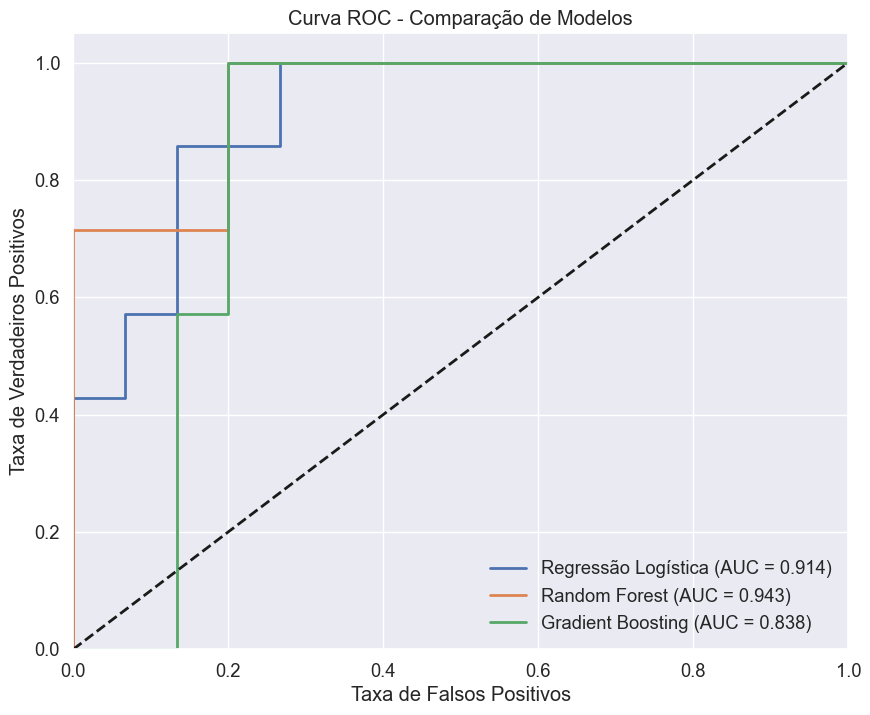

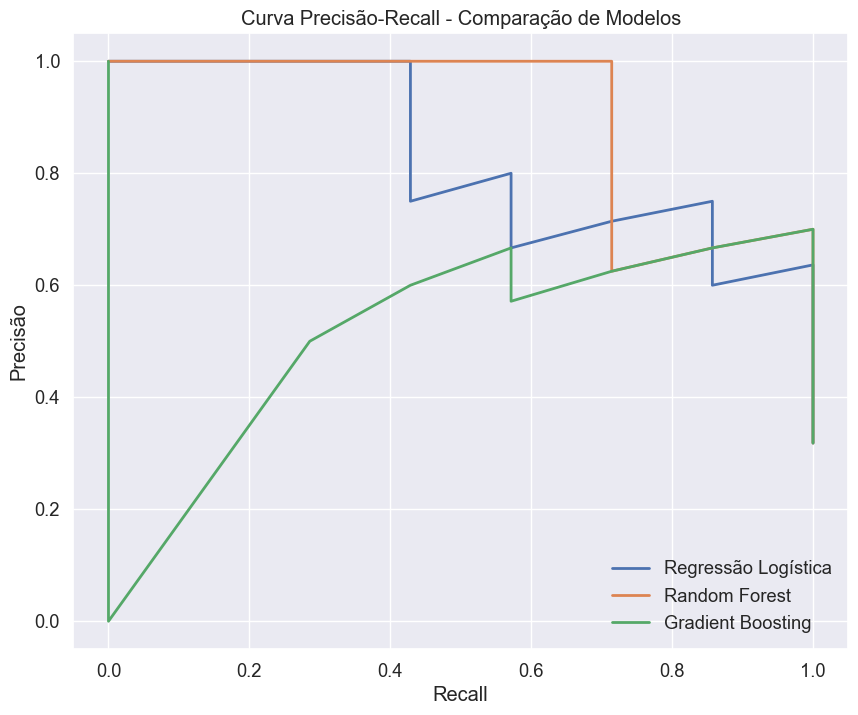

In [8]:
################################################################################
# 8. Avaliação dos Modelos
################################################################################

# Comparar desempenhos no conjunto de teste
for name, result in results.items():
    print(f"\nAvaliação do modelo: {name}")
    print("\nMatriz de Confusão:")
    cm = confusion_matrix(y_test, result['y_pred'])
    print(cm)
    
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, result['y_pred']))
    
    # Calcular AUC
    fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
    auc_score = auc(fpr, tpr)
    print(f"AUC: {auc_score:.4f}")

# Visualizar curvas ROC
plt.figure(figsize=(10, 8))

for name, result in results.items():
    y_prob = result['y_prob']
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Comparação de Modelos')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Visualizar curvas de precisão-recall
plt.figure(figsize=(10, 8))

for name, result in results.items():
    y_prob = result['y_prob']
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, lw=2, label=f'{name}')

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precisão-Recall - Comparação de Modelos')
plt.legend(loc="best")
plt.grid(True)
plt.show()

Transformers no preprocessor: [('num', StandardScaler(), ['total_checkins', 'media_checkins_semana', 'dias_desde_ultimo_checkin', 'duracao_media_minutos', 'variacao_duracao', 'dias_consecutivos_max', 'percentual_manha', 'percentual_tarde', 'percentual_noite', 'plano_id', 'valor_mensal', 'dias_desde_inscricao']), ('cat', OneHotEncoder(handle_unknown='ignore'), ['plano_nome'])]
Features categóricas: ['plano_nome']
Transformador categórico: OneHotEncoder(handle_unknown='ignore')
Categorias encontradas: [array(['Básico', 'Premium', 'VIP'], dtype=object)]
Feature: plano_nome, Valores: ['Básico' 'Premium' 'VIP']
Número de nomes de features: 15
Número de importâncias de features: 15
Feature names: ['total_checkins', 'media_checkins_semana', 'dias_desde_ultimo_checkin', 'duracao_media_minutos', 'variacao_duracao', 'dias_consecutivos_max', 'percentual_manha', 'percentual_tarde', 'percentual_noite', 'plano_id', 'valor_mensal', 'dias_desde_inscricao', 'plano_nome_Básico', 'plano_nome_Premium', 'p

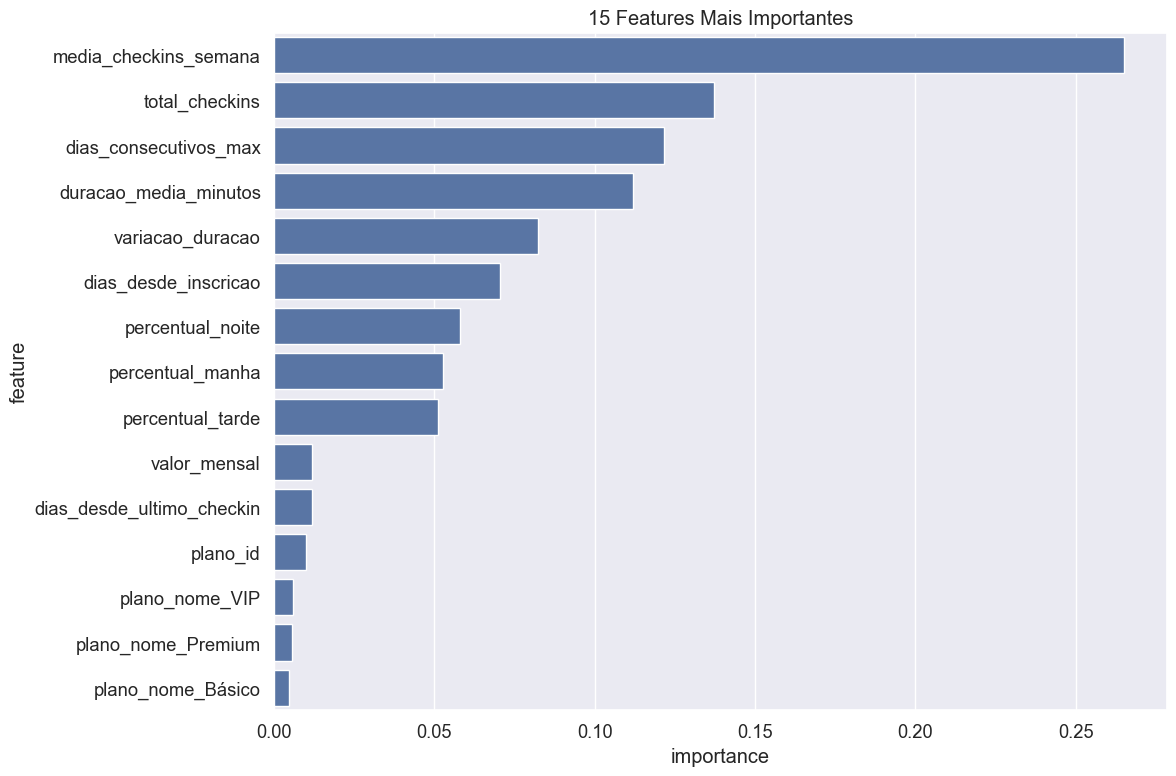

In [9]:
################################################################################
# 9. Importância das Features
################################################################################

# Analisar importância das features (usando o modelo Random Forest)
best_model_name = 'Random Forest'  # Escolha o melhor modelo baseado nas avaliações anteriores
best_model = results[best_model_name]['model']

# Obter feature names após a transformação
preproc = best_model.named_steps['preprocessor']

# Verificar a estrutura do preprocessor
print(f"Transformers no preprocessor: {preproc.transformers}")

# Identificar o índice do transformer categórico
cat_idx = np.flatnonzero(np.array([name for name, _, _ in preproc.transformers_])=='cat')[0]
cat_transformer = preproc.transformers_[cat_idx][1]
cat_features = preproc.transformers_[cat_idx][2]

# Verificar detalhes do transformer categórico
print(f"Features categóricas: {cat_features}")
print(f"Transformador categórico: {cat_transformer}")
if hasattr(cat_transformer, 'categories_'):
    print(f"Categorias encontradas: {cat_transformer.categories_}")

# Obter todas as categorias após one-hot encoding
cat_columns = []
for i, feature in enumerate(cat_features):
    cat_values = cat_transformer.categories_[i]
    print(f"Feature: {feature}, Valores: {cat_values}")
    cat_columns.extend([f"{feature}_{val}" for val in cat_values])

# Verificar detalhes do transformer numérico
num_idx = np.flatnonzero(np.array([name for name, _, _ in preproc.transformers_])=='num')[0]
numeric_features = preproc.transformers_[num_idx][2]

# Combinar com features numéricas
feature_names = list(numeric_features) + cat_columns

# Obter importância das features
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Verificar tamanhos
print(f"Número de nomes de features: {len(feature_names)}")
print(f"Número de importâncias de features: {len(feature_importances)}")
print(f"Feature names: {feature_names}")

# Criar DataFrame de importâncias
if len(feature_names) == len(feature_importances):
    importances_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)

    # Visualizar importância das features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=importances_df.head(15))
    plt.title('15 Features Mais Importantes')
    plt.tight_layout()
    plt.show()
else:
    print("Erro: O número de nomes de features não corresponde ao número de importâncias")
    print(f"Diferença: {abs(len(feature_names) - len(feature_importances))}")

Top 20 alunos ativos com maior risco de churn:
                  nome plano_nome  probabilidade_churn  \
23     Bruno Rodrigues        VIP                 0.80   
16         Diego Costa     Básico                 0.75   
65       Felipe Araújo     Básico                 0.69   
40    Miguel Fernandes     Básico                 0.22   
85      Rafael Ribeiro    Premium                 0.21   
77         Alice Alves    Premium                 0.20   
54      Gustavo Vieira     Básico                 0.18   
104  Aluno Teste dias2    Premium                 0.18   
92    Leonardo Bezerra     Básico                 0.17   
66   Isabella Teixeira     Básico                 0.17   
88           Ana Souza    Premium                 0.15   
103   Aluno Teste dias     Básico                 0.14   
25        João Barbosa    Premium                 0.13   
44        Sophia Souza    Premium                 0.13   
3        Carlos Santos     Básico                 0.12   
100              teste   

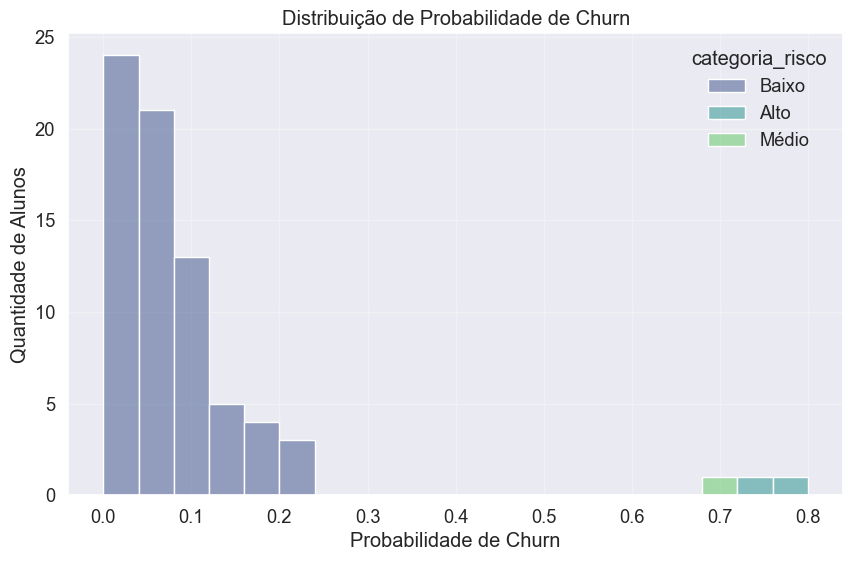

In [10]:
################################################################################
# 10. Previsões e Aplicação do Modelo
################################################################################

# Selecionar o melhor modelo com base nas avaliações anteriores
best_model = results[best_model_name]['model']

# Aplicar o modelo a todos os alunos
X_all = df_features.drop(features_para_remover, axis=1)
probabilidades = best_model.predict_proba(X_all)[:, 1]

# Adicionar probabilidades ao DataFrame de features
df_features['probabilidade_churn'] = probabilidades

# Ordenar alunos pelo risco de churn (apenas alunos ativos)
alunos_ativos = df_features[df_features['churn'] == 0].copy()
alunos_risco = alunos_ativos.sort_values('probabilidade_churn', ascending=False)

# Exibir os 20 alunos ativos com maior risco de churn
print("Top 20 alunos ativos com maior risco de churn:")
print(alunos_risco[['nome', 'plano_nome', 'probabilidade_churn', 'dias_desde_ultimo_checkin', 'media_checkins_semana']].head(20))

# Definir níveis de risco
def categorizar_risco(probabilidade):
    if probabilidade >= 0.7:
        return "Alto"
    elif probabilidade >= 0.4:
        return "Médio"
    else:
        return "Baixo"

# Adicionar categorias de risco
alunos_ativos['categoria_risco'] = alunos_ativos['probabilidade_churn'].apply(categorizar_risco)

# Contar alunos por categoria de risco
contagem_risco = alunos_ativos['categoria_risco'].value_counts()
print("Distribuição de alunos ativos por categoria de risco:")
print(contagem_risco)

# Visualizar distribuição das probabilidades
plt.figure(figsize=(10, 6))
sns.histplot(data=alunos_ativos, x='probabilidade_churn', bins=20, hue='categoria_risco', palette='viridis')
plt.title('Distribuição de Probabilidade de Churn')
plt.xlabel('Probabilidade de Churn')
plt.ylabel('Quantidade de Alunos')
plt.grid(True, alpha=0.3)
plt.show()


In [11]:
################################################################################
# 11. Estratégias de Retenção
################################################################################

# Analisar características dos alunos de alto risco
alunos_alto_risco = alunos_ativos[alunos_ativos['categoria_risco'] == 'Alto']

# Estatísticas dos alunos de alto risco
print("Estatísticas dos alunos com alto risco de churn:")
print(alunos_alto_risco[['dias_desde_ultimo_checkin', 'media_checkins_semana', 'total_checkins', 
                        'duracao_media_minutos', 'dias_consecutivos_max']].describe())

# Principais características dos alunos de alto risco
print("\nPrincipais padrões identificados nos alunos de alto risco:")
print(f"- Média de dias desde o último check-in: {alunos_alto_risco['dias_desde_ultimo_checkin'].mean():.1f} dias")
print(f"- Média de check-ins por semana: {alunos_alto_risco['media_checkins_semana'].mean():.2f} visitas")
print(f"- Duração média das visitas: {alunos_alto_risco['duracao_media_minutos'].mean():.1f} minutos")

# Distribuição de planos entre alunos de alto risco
print("\nDistribuição de planos entre alunos de alto risco:")
print(alunos_alto_risco['plano_nome'].value_counts(normalize=True) * 100)

Estatísticas dos alunos com alto risco de churn:
       dias_desde_ultimo_checkin  media_checkins_semana  total_checkins  \
count                        2.0               2.000000        2.000000   
mean                         0.0               0.519298       20.500000   
std                          0.0               0.227496        4.949747   
min                          0.0               0.358434       17.000000   
25%                          0.0               0.438866       18.750000   
50%                          0.0               0.519298       20.500000   
75%                          0.0               0.599730       22.250000   
max                          0.0               0.680162       24.000000   

       duracao_media_minutos  dias_consecutivos_max  
count               2.000000               2.000000  
mean               66.549020               1.500000  
std                 0.305026               0.707107  
min                66.333333               1.000000  
25%  

In [12]:
################################################################################
# 12. Salvando o Modelo
################################################################################

# Salvar o modelo usando joblib
import joblib

# Criar diretório para modelos se não existir
import os
os.makedirs('../models', exist_ok=True)

# Salvar o modelo
modelo_path = '../models/modelo_churn.pkl'
joblib.dump(best_model, modelo_path)
print(f"Modelo salvo em: {modelo_path}")

# Salvar também informações das features para uso futuro
feature_info = {
    'feature_names': list(X.columns),
    'categorical_features': features_categoricas,
    'numerical_features': features_numericas
}
joblib.dump(feature_info, '../models/feature_info.pkl')
print(f"Informações das features salvas em: ../models/feature_info.pkl")

Modelo salvo em: ../models/modelo_churn.pkl
Informações das features salvas em: ../models/feature_info.pkl


In [13]:
################################################################################
# 13. Salvando as Probabilidades no Banco de Dados
################################################################################

# Gravar as probabilidades de churn no banco de dados
from sqlalchemy import Column, Integer, Float, DateTime, Table, MetaData, String, create_engine, inspect

print("\nSalvando as probabilidades de churn no banco de dados...")

try:
    # Verificar se a tabela já existe
    inspector = inspect(engine)
    table_exists = 'probabilidades_churn' in inspector.get_table_names()
    
    # Criar a tabela se não existir
    if not table_exists:
        print("Criando tabela 'probabilidades_churn'...")
        metadata = MetaData()
        
        # Definir a estrutura da tabela
        probabilidades_table = Table(
            'probabilidades_churn',
            metadata,
            Column('id', Integer, primary_key=True),
            Column('aluno_id', Integer, nullable=False),
            Column('probabilidade', Float, nullable=False),
            Column('categoria_risco', String(10), nullable=False),
            Column('data_analise', DateTime, nullable=False),
        )
        
        # Criar a tabela no banco de dados
        metadata.create_all(engine)
        print("Tabela 'probabilidades_churn' criada com sucesso!")
    else:
        print("Tabela 'probabilidades_churn' já existe.")
    
    # Preparar os dados para inserção
    from datetime import datetime
    data_atual = datetime.now()
    
    # Criar registros para cada aluno ativo
    registros = []
    for _, aluno in alunos_ativos.iterrows():
        registros.append({
            'aluno_id': int(aluno['aluno_id']),
            'probabilidade': float(aluno['probabilidade_churn']),
            'categoria_risco': aluno['categoria_risco'],
            'data_analise': data_atual
        })
    
    # Inserir os registros na tabela
    with engine.connect() as conn:
        # Inserir os registros usando transação
        with conn.begin():
            # Inserir usando SQL raw para maior compatibilidade
            for registro in registros:
                sql = f"""
                INSERT INTO probabilidades_churn (aluno_id, probabilidade, categoria_risco, data_analise)
                VALUES ({registro['aluno_id']}, {registro['probabilidade']}, '{registro['categoria_risco']}', '{registro['data_analise']}')
                """
                conn.execute(text(sql))
    
    print(f"Inseridas {len(registros)} probabilidades de churn no banco de dados.")

except Exception as e:
    print(f"Erro ao salvar probabilidades no banco de dados: {e}")

# Verificar os dados inseridos
try:
    # Consultar os registros mais recentes
    query = """
    SELECT 
        pc.aluno_id, 
        a.nome as nome_aluno,
        pc.probabilidade, 
        pc.categoria_risco, 
        pc.data_analise
    FROM 
        probabilidades_churn pc
    JOIN 
        alunos a ON pc.aluno_id = a.id
    ORDER BY 
        pc.data_analise DESC, pc.probabilidade DESC
    LIMIT 10
    """
    
    df_prob = pd.read_sql(query, engine)
    print("\nÚltimas probabilidades registradas:")
    print(df_prob)
    
except Exception as e:
    print(f"Erro ao consultar probabilidades: {e}")


Salvando as probabilidades de churn no banco de dados...
Criando tabela 'probabilidades_churn'...
Tabela 'probabilidades_churn' criada com sucesso!
Inseridas 73 probabilidades de churn no banco de dados.

Últimas probabilidades registradas:
   aluno_id         nome_aluno  probabilidade categoria_risco  \
0       576    Bruno Rodrigues           0.80            Alto   
1       569        Diego Costa           0.75            Alto   
2       618      Felipe Araújo           0.69           Médio   
3       593   Miguel Fernandes           0.22           Baixo   
4       638     Rafael Ribeiro           0.21           Baixo   
5       630        Alice Alves           0.20           Baixo   
6       607     Gustavo Vieira           0.18           Baixo   
7       657  Aluno Teste dias2           0.18           Baixo   
8       619  Isabella Teixeira           0.17           Baixo   
9       645   Leonardo Bezerra           0.17           Baixo   

                data_analise  
0 2025-04-0